# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd 'your_drive'

In [ ]:
!pip install transformers
import math
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np


In [ ]:
SEED = 1111

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Dataset

In [ ]:
from pathlib import Path
import sys
sys.path.insert(0,str(Path().absolute().joinpath("data")))
from data import prepareData
import random
random.seed(SEED)
from torch.utils.data import random_split

SOS_token = 0
EOS_token = 1

MAX_LENGTH = 10

TRAIN_RATIO = 0.6
VALID_RATIO = 0.2

# BATCH_SIZE = 64
BATCH_SIZE = 1


In [ ]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length=max_length

        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']
        
        print("data example")
        print(random.choice(self.pairs))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)
    
    def collate_fn(self, data):
        x_batch = []; y_batch = []
        
        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))
        
        return torch.stack(x_batch), torch.stack(y_batch)

dataset = TranslateDataset(max_length=MAX_LENGTH)

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

In [ ]:
sample_x, sample_y = next(iter(train_dataloader))
sample_x = sample_x.squeeze(0)
sample_y = sample_y.squeeze(0)

print("Sample sentences\n")
print("sample_x: ", sample_x)
print(' '.join([dataset.input_lang.index2word[i] for i in sample_x.tolist()]))
print("sample_y: ", sample_y)
print(' '.join([dataset.output_lang.index2word[i] for i in sample_y.tolist()]))

# 1. Seq2seq model with Attention Mechanism

In [ ]:
#############################
##### Initialize Model ######
#############################

in_dim =  # french
out_dim =  # english

emb_dim =  # embbeding size
hid_dim =  # vector size of encoder output

print(f'\nin_dim: {in_dim}\tout_dim: {out_dim}\temb_dim: {emb_dim}\thid_dim: {hid_dim}\n')

## Encoder

In [ ]:
#############################
####### Prepare Input ####### 
#############################

print('Encoder Embedding outputs')

embedded_x = nn.Embedding(in_dim, emb_dim)(sample_x)
print(embedded_x.shape)

In [ ]:
print('Initialize hidden and cell states')

hidden_0 =  # (1, Hout) for unbatched input
cell_0 =  # (1, Hcell) for unbatched input

In [ ]:
#############################
### Get output of Encoder ###
#############################
 
lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim)
hiddens, (hidden, cell) = lstm(embedded_x, (hidden_0, cell_0))
# hiddens = lstm(embedded_x, (hidden_0, cell_0))

print('LSTM Encoder outputs')
print(f'hiddens: {hiddens.shape}\thidden: {hidden.shape}\tcell: {cell.shape}')

enc_hiddens = hiddens # assign encoder outputs for decoder(w/attention, see below)

In [ ]:
# torch.sum(hiddens[-1]-hidden) # last value of hiddens = hidden

## Decoder

In [ ]:
#############################
###### Prepare Output ####### 
#############################

print('Decoder Embedding outputs')

dec_embedder = nn.Embedding(out_dim, emb_dim)
embedded_y = dec_embedder(sample_y) # ground truth
print(embedded_y.shape)

In [ ]:
#############################
####### Prepare Input ####### 
#############################

cell_0 = torch.zeros(1, hid_dim)

input = embedded_y[0] # [SOS]
enc_output = hiddens[-1] # hidden
hidden = enc_output.unsqueeze(0)
cell = cell_0

In [ ]:
#############################
### Get output of Decoder ###
#############################

seq2seq_outputs = []
decoder = nn.LSTM(input_size=emb_dim+hid_dim, hidden_size=hid_dim)
fc = nn.Linear(hid_dim, out_dim)

for t in range(MAX_LENGTH):

    input_encout_concat = torch.concat([input, enc_output])
    
    hiddens, (hidden, cell) = decoder(input_encout_concat.unsqueeze(0), (hidden, cell))
    
    next_token_idx = F.softmax(fc(hidden)).max(1)[1]
    
    seq2seq_outputs.append(hiddens)
    

    # Update inputs for the next loop
    
    input = dec_embedder(next_token_idx).squeeze(0)
    # hidden = hidden
    # cell = cell



    if t==0: 
        print(f'input_encout_concat: {input_encout_concat.shape}')
        print('\nLSTM Decoder outputs')
        print(f'hiddens: {hiddens.shape}\thidden: {hidden.shape}\tcell: {cell.shape}')
    

In [ ]:
seq2seq_outputs = torch.stack(seq2seq_outputs)
seq2seq_outputs.shape # predicted

### Attention

In [ ]:
#############################
## Set key/value and query ##
#############################

# key, value
kv = enc_hiddens
print("Key/value shape:\t",  kv.shape)

# query
example_t = 4 # any int [0 ~ MAX_LENGTH-1]
q = seq2seq_outputs[example_t]
print("Query shape:\t",  q.shape)

Key/value shape:	 torch.Size([10, 512])
Query shape:	 torch.Size([1, 512])


In [ ]:
#############################
#### Get attention value ####
#############################

attn_score =  #(10, 1)

attn_coefficient =  #(10, 1)

weighted_kv = kv*attn_coefficient
weighted_sum = torch.sum(weighted_kv, dim=0) # attention value

print("attn_score shape:\t",  attn_score.shape)
print("weights: \t", attn_coefficient.squeeze(1).tolist())
print("total of weights: \t", sum(attn_coefficient.squeeze(1).tolist()))
print("weighted sum of val:\t", weighted_kv.shape)
print("weighted sum:\t", weighted_sum.shape)

attn_score shape:	 torch.Size([10, 1])
weights: 	 [0.06483325362205505, 0.09662076085805893, 0.10265860706567764, 0.09185811132192612, 0.06566578149795532, 0.089730404317379, 0.1004531979560852, 0.1402510553598404, 0.10215922445058823, 0.14576959609985352]
total of weights: 	 0.9999999925494194
weighted sum of val:	 torch.Size([10, 512])
weighted sum:	 torch.Size([512])


In [ ]:
sample_idx = 4  # which index of encoder output to attend [0~9]

print("before attn")
print(sum(kv[sample_idx]))
print("attn weight")
print(attn_coefficient[sample_idx])
print("after attn")
print(sum(weighted_kv[sample_idx]))

before attn
tensor(-0.9780, grad_fn=<AddBackward0>)
attn weight
tensor([0.0657], grad_fn=<SelectBackward0>)
after attn
tensor(-0.0642, grad_fn=<AddBackward0>)


# 2. Seq2seq model with Transformer

In [ ]:
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
emb_dim = 256

In [ ]:
#############################
########### Input ########### 
#############################

embedded_x = nn.Embedding(in_dim, emb_dim)(sample_x)
print("embedded_x:\t", embedded_x.shape)

Positional Encoding
1. Absolute sinusoid-based Positional Encoding
2. Relative Positional Encoding
3. Learnable Embedding (using nn.Embedding)

In [ ]:
#############################
##### Position Encoding #####
#############################

import matplotlib.pyplot as plt

# Learnable
# pos = torch.arange(MAX_LENGTH).unsqueeze(1)
# pos_embedding = nn.Embedding(in_dim, emb_dim)(pos)
# plt.pcolormesh(pos_embedding.squeeze(1).detach().numpy(), cmap='RdBu') # Learnable

# Absolute
with open('absolute_pe.pickle', 'rb') as handle:
    pe = pickle.load(handle)
plt.pcolormesh(pe.squeeze(1), cmap='RdBu')


plt.xlim((0, emb_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()


In [ ]:
embedded_pos = embedded_x + pe.squeeze(1)
print("embedded_pos:\t",embedded_pos.shape)

In [ ]:
#############################
##### src * trg masking #####
#############################

# source masking
sample_x_mask = (sample_x == dataset.input_lang_pad)

print("source mask = pad masking")
print(sample_x_mask.squeeze().tolist())

# target masking
pad_mask_neg = (sample_y != dataset.output_lang_pad).unsqueeze(1).unsqueeze(2)
sub_mask = torch.tril(torch.ones((MAX_LENGTH, MAX_LENGTH))).bool()
sample_y_mask = pad_mask_neg.permute(2,1,0) & sub_mask.unsqueeze(0)

print("\ntarget mask = pad masking + subsequent masking")
print(pad_mask_neg.squeeze().tolist())
print()
print(sub_mask.squeeze())
print()
print(sample_y_mask.squeeze())

In [ ]:
#############################
########### Model ########### 
#############################

from torch.nn import Transformer

hid_dim = emb_dim
ff_dim = 1024
n_heads = 8
n_enc_layers = 3
n_dec_layers = 5
dropout_p = 0.1

class TransSeq2Seq(nn.Module):
    
    def __init__(self, hid_dim, ff_dim, n_heads, n_enc_layers, n_dec_layers, dropout_p):
        super().__init__()
        self.input_emb = nn.Embedding(in_dim, hid_dim)
        self.output_emb = nn.Embedding(out_dim, hid_dim)
        self.pos_emb = nn.Embedding(MAX_LENGTH, hid_dim)

        self.transformer = Transformer(d_model=hid_dim,
                                       nhead=n_heads,
                                       num_encoder_layers=n_enc_layers,
                                       num_decoder_layers=n_dec_layers,
                                       dim_feedforward = ff_dim,
                                       dropout = dropout_p,
                                       activation = 'gelu')
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, src, trg):
        
        embedded_pos = self.pos_emb(torch.arange(MAX_LENGTH).unsqueeze(1))
        embedded_x = self.input_emb(src)
        embedded_y = self.output_emb(trg)

        embedded_x = self.dropout(torch.sum(embedded_x + embedded_pos, dim=1))
        embedded_y = self.dropout(torch.sum(embedded_y + embedded_pos, dim=1))

        return self.transformer(embedded_x, embedded_y)



In [ ]:
model = TransSeq2Seq(hid_dim, ff_dim, n_heads, n_enc_layers, n_dec_layers, dropout_p)
print(model)

In [ ]:
out = model(sample_x, sample_y)
print(out.shape)

# 3. Bert fine-tuning

ref.

1. [huggingface BERT documentation](https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#bert)

2. [masked language modelling with bert](https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c)

3. [fine-tuning bert for text classification in pytorch](https://luv-bansal.medium.com/fine-tuning-bert-for-text-classification-in-pytorch-503d97342db2)

4. [pytorch sentiment classification github](https://github.com/clairett/pytorch-sentiment-classification/tree/master/data/SST2)

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
from tqdm import tqdm
from torch.optim import AdamW

MX_LENGTH = 50
BATCH_SIZE = 32
MASK_RATIO = 0.2
EPOCHS = 3
learning_rate = 5e-3 #5e-5 -> loss: 1~2 after one epoch

## Prepare dataset

In [ ]:
class BertDataset(Dataset):
    def __init__(self, tokenizer, max_length=512, mask_ratio=0.15):
        super(BertDataset, self).__init__()
        # self.root_dir='./data'
        self.train_csv=pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
        self.tokenizer=tokenizer
        self.target=self.train_csv.iloc[:,1]
        self.max_length = max_length
        self.mask_ratio = mask_ratio

    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        
        inputs = self.tokenizer.encode_plus(text=self.train_csv.iloc[index,0],
                                            padding='max_length',
                                            truncation=True,
                                            add_special_tokens=True,
                                            return_tensors='pt',
                                            max_length=self.max_length,)

        return {'input_ids': inputs["input_ids"].clone().detach(),
                'token_type_ids': inputs["token_type_ids"].clone().detach(),}

    def _apply_masking(self, x):
        rand = torch.rand(x['input_ids'].shape)
        mask = (rand < self.mask_ratio) * (x['input_ids'] != 101) * (x['input_ids'] != 102) * (x['input_ids'] != 0) # t/f tensor

        selection = torch.flatten(mask[0].nonzero()).tolist() # idxs masked
        x['input_ids'][0, selection] = 103 # apply MASK token

        return x

    def collate_fn(self, data):
        batch={'input_ids':None, 'labels':None}
        
        # copy ids
        tmp = [item['input_ids'] for item in data]
        batch['labels'] = torch.stack(tmp).squeeze(1)
        
        # create mask tensor
        data = list(map(self._apply_masking, data))
        tmp = [item['input_ids'] for item in data]
        batch['input_ids'] = torch.stack(tmp).squeeze(1)

        return batch

In [ ]:

# dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset= BertDataset(tokenizer, max_length=MX_LENGTH, mask_ratio=MASK_RATIO)

# dataloader
dataloader=DataLoader(dataset=dataset,batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn)


In [ ]:
#############################
###### Explore Dataset ######
#############################

for i, batch_data in enumerate(dataloader):
    if i==0:
        print("data shape")
        print(batch_data['labels'].shape) # batch_size * max_length
        print()
        print("before masking")
        print(batch_data['labels'][0]) # 101: CLS, 102: SEP / we use single sentence for fine-tuning task
        print()
        print("after masking (MASK = 103)")
        print(batch_data['input_ids'][0])

## Prepare model

In [ ]:
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [ ]:
for i, batch_data in enumerate(dataloader):
    if i==0:
        print(model(**batch_data).loss)

## Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()
optim = AdamW(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(EPOCHS):
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        optim.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

Epoch 2: 100%|██████████| 217/217 [01:20<00:00,  2.68it/s, loss=4.72]


In [102]:
import numpy as np
import matplotlib.pyplot as plt
data = np.array(((1,1),(2,3),(3,4),(-0.5,-0.5), (-1,-2),(-2,-3),( -3,-4),(-4,-3)))
label = np.array((1,1,1,-1,-1,-1,-1,-1))

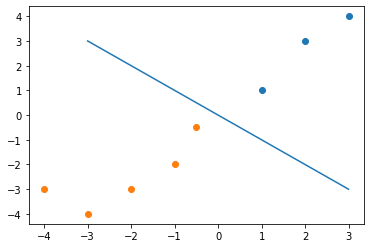

In [103]:
plt.scatter(data[:3,0],data[:3,1])
plt.scatter(data[3:,0],data[3:,1])
haha = np.linspace(-3,3)
plt.plot(haha,-haha)
plt.show()

In [104]:
def perceptron(theta, theta_0, data, label):
    for i,x in enumerate(data):
        if label[i]*(theta@x + theta_0) <= 0:
            theta = theta+label[i]*x
            theta_0 = theta_0 + label[i]
    return theta, theta_0        

In [105]:
theta = np.array([0,0])
theta_0 = 0
perceptron(theta, theta_0, data, label) #data[:4], label[:4])

(array([1.5, 1.5]), 0)

In [106]:
transformed_data = (np.array([[0.5,-np.sqrt(3)/2],[np.sqrt(3)/2,0.5]]) @ data.T).T

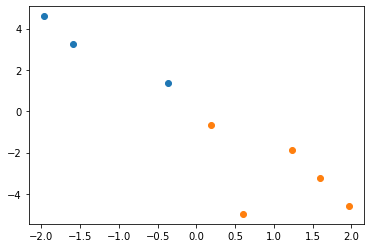

In [107]:
plt.scatter(transformed_data[:3,0],transformed_data[:3,1])
plt.scatter(transformed_data[3:,0],transformed_data[3:,1])

In [110]:
theta =  np.array([0,0])
theta_0 = 0
perceptron(theta, theta_0, transformed_data, label) #data[:4], label[:4])

(array([-0.54903811,  2.04903811]), 0)

In [111]:
perceptron(theta, theta_0, transformed_data, label) #data[:4], label[:4])

(array([-0.54903811,  2.04903811]), 0)

In [97]:
transformed_data[1]

array([-1.59807621,  3.23205081])

In [98]:
transformed_data

array([[-0.3660254 ,  1.3660254 ],
       [-1.59807621,  3.23205081],
       [-1.96410162,  4.59807621],
       [ 0.1830127 , -0.6830127 ],
       [ 1.23205081, -1.8660254 ],
       [ 1.59807621, -3.23205081],
       [ 1.96410162, -4.59807621],
       [ 0.59807621, -4.96410162]])

In [100]:
0.5+np.sqrt(3)/2

1.3660254037844386

In [58]:
perceptron(theta, theta_0, data, label) #data[:4], label[:4])

(array([1.5, 1.5]), 0)

In [59]:
label[:5]

array([ 1,  1,  1, -1, -1])

In [80]:
def perceptron(theta,  data, label):
    for i,x in enumerate(data):
        if label[i]*(theta@x) <= 0:
            theta = theta+label[i]*x
            #theta_0 = theta_0 + label[i]
            print("haha")
    return theta       

In [83]:
theta = np.array([1,5])
perceptron(theta,  data, label) #data[:4], label[:4])

array([1, 5])

In [72]:
perceptron(theta,  data, label) #data[:4], label[:4])

array([1., 1.])